In [1]:
##### Here is a file based on the calculation shown in the article 
##### J. Phys. Chem. B 2014, 118, 6466−6474
##### See ""Support Information"" for Multi-dimensional case

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
##### Define parameters/constants

## time scale
Nmax = 10000 ## Define the maximum of steps
dt = 1e-8 ## Define the time gap ∆t (s) for each step

## enviroment
T = 298 # temperature (K)
k_B = 1.38064852*10e-23 # Boltzmann constant
beta = 1/(k_B*T)

## mass & effective mass on each direction
mass = 1e-6 # mass of the column, with unit of kg
rayon = 1e-6 # 1µm = 10^{-6}m, with unit of meter
mz = mass
mx = mass
mt = mass*rayon**2/2

m = np.zeros(3)
m[0] = mz
m[1] = mx
m[2] = mt
grav = 9.80665 # Gravitational acceleration, with unit of m/s^2

## solvent property
kappa = 1e-4*0 ## compliance, 10^{-4} ~ 10 ^{-3}
eps = 0.1 ## arbitrary value temporarily
xi = 1 ## arbitrary value temporarily
kxi = kappa*xi
kxe = kappa*xi*eps

## relevant coefficients
coefa = np.zeros(7)
coefb = np.zeros(7)
coefc = np.zeros(7)

coefa[1] = xi
coefa[2] = 21*kxi/4
coefa[3] = -kxi/4
coefa[4] = kxi/2
coefa[5] = -15*kxi/8
coefa[6] = 1

coefb[1] = 2*eps*xi/3
coefb[2] = 19*kxe/24
coefb[3] = -kxe/6
coefb[4] = kxe/12
coefb[5] = -kxe/12
coefb[6] = 0

coefc=coefb*2

In [4]:
def _gammavalue(i,j,z,vz,vx,vt):
    """
    This function would furnish the value of gamma matrix
    i,j: matrix index
    kappa,eps,xi: constant/parameters
    z: vertical position
    vz,vx,vt: velocity vector
    """
    zroot = np.sqrt(z)
    
    if (i==0)and(j==0):
        return xi/zroot**3 + ((15*xi)/(8*z**5) + (21*vz)/(4*zroot**9))*kappa*xi
    if (i==1)and(j==1):
        return (2*eps*xi)/(3*zroot) + (4*zroot*eps**2*xi+18*vz+57*eps*vt)*kappa*xi/(72*zroot**7)
    if (i==2)and(j==2):
        return (4*eps*xi)/(3*zroot) + ((2*eps**2*xi)/(9*z**3) + ((3+19*eps)*vz)/(12*zroot**7))*kappa*xi
    if (i+j==1):
        return xi*kappa*((3+eps)*vt-3*vx)/(12*zroot**7)
    if (i+j==2)and(i*j==0):
        return xi*kappa*((3-eps)*vx-3*vt)/(12*zroot**7)
    if (i+j==3):
        return ((eps**2*xi)/(9*z**3) - ((1+eps)*vz)/(4*zroot**7))*kappa*xi


In [5]:
def _forcevalue(i,z,vz,vx,vt):
    """
    This function would furnish the force on each direction
    i: index, refers to z/x/t(theta)
    z: vertical position
    vz,vx,vt: velocity vector
    """
    zroot = np.sqrt(z)
    if (i==0):
        return -mz*(coefa[1]*vz/(zroot**3)+
                    coefa[2]*vz**2/(zroot*9)+
                    coefa[3]*(vx**2+vt**2)/(zroot**7)+
                    coefa[4]*vx*vt/(zroot**7)+
                    coefa[6]) + grav*mz
    if (i==1):
        return -mx*(coefb[1]*vx/zroot+
                    coefb[2]*vz*vx/(zroot**7)+
                    coefb[3]*vz*vt/(zroot**7)+
                    coefb[6])
    if (i==2):
        return -mt*(coefc[1]*vt/zroot+
                    coefc[2]*vz*vt/(zroot**7)+
                    coefc[3]*vz*vx/(zroot**7)+
                    coefc[6])

In [6]:
def _Minverse(i,j,z):
    """
    This function would furnish the inverse M
    i,j: index; z: vertical distance
    """
    zroot = np.sqrt(z)
    if (i+j==0):
        return 1/mz * (1 + (15*kxi)/(8*zroot**5))
    if (i*j==1):
        return 1/mx * (1 + kxe/(12*zroot**5))
    if (i==1)and(j==2):
        return -kxe/(12*zroot**5*mt)
    if (i==2)and(j==1):
        return -kxe/(6*zroot**5*mx)
    if (i+j==4):
        return 1/mt * (1 + kxe/(6*zroot**5))
    if (i*j==0)and(i+j!=0):
        return 0

In [7]:
##### Define position/velocity/force vectors
position = np.zeros((Nmax,3)) ## first index for time step, second index for z/x/t(theta)
velocity = np.zeros((Nmax,3)) ## first index for time step, second index for z/x/t(theta)
force = np.zeros((Nmax,3)) ## first index for time step, second index for z/x/t(theta)

##### Define gamma matrix
gamma = np.zeros((3,3))
##### Define intermediate variable a&b related to gamma matrix
intma = np.zeros((3,3))
intmb = np.zeros((3,3))

##### Define M inverse matrix
Minv = np.zeros((3,3))



In [ ]:
def _updategamma(z,vz,vx,vt):
    """
    This procedure would update the value of gamma matrix
    z: vertical position
    vz,vx,vt: velocity on each direction
    """
    for i in range(3):
        for j in range(3):
            gamma[i,j] = _gammavalue(i,j,z,vz,vx,vt)

In [ ]:
def _updateforce(indice,z,vz,vx,vt):
    """
    This procedure would update the value of force vector
    indice: refers to the time step
    z: vertical position
    vz,vx,vt: velocity on each direction
    """
    for i in range(3):
        force[indice,i] = _forcevalue(i,z,vz,vx,vt)

In [8]:
def _updateMinverse(z):
    """
    This procedure would update the value of Minverse
    z: vertical position
    """
    for i in range(3):
        for j in range(3):
            Minv[i,j] = _Minverse(i,j,z)


def _updateintm():
    """
    This procedure would update the values of intma & intmb
    ## a=exp(-gamma*dt)
    ## b=sqrt(2/(gamma*dt)*tanh(gamma*dt/2))
    """
    intma=np.exp(-gamma*dt)
    
    gt2=gamma*dt/2
    for i in range(3):
        for j in range(3):
            if (gamma[i,j]==0):
                intmb[i,j] = 1 # Consider the limit if gamma->0 to avoid "nan"
            else:
                intmb[i,j] = np.sqrt(np.tanh(gt2[i,j])/gt2[i,j])

In [9]:
### initial height
position[0,0] = 1e-7
velocity[0,:] = np.random.default_rng().normal(loc=0.0, scale=1.0, size=3)*1e-6 # if kappa=0, no correction about velocity

## gamma matrix initiation
_updategamma(position[0,0],velocity[0,0],velocity[0,1],velocity[0,2])
## intma & intmb initiation
_updateintm()
## force vector initiation
_updateforce(0,position[0,0],velocity[0,0],velocity[0,1],velocity[0,2])
## M inverse matrix initiation
_updateMinverse(position[0,0])

In [10]:
print("gamma=")
print(gamma)
print("")

print("intma=")
print(intma)
print("")

print("intmb=")
print(intmb)
print("")

print("intma dot intmb")
print(intma@intmb)
print("")

print("np.sqrt(intma)")
print(np.sqrt(intma))
print("")

print("np.dot(np.sqrt(intma),velocity[0,:])")
print(np.dot(np.sqrt(intma),velocity[0,:]))
print("")

print("Initial force vector = ")
print(force[0,:])
print("")

print("Initial Minverse matrix = ")
print(Minv)
print("")

gamma=
[[ 3.16227766e+10  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  2.10818511e+02  0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  4.21637021e+02]]

intma=
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

intmb=
[[0.07952707 1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]]

intma dot intmb
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

np.sqrt(intma)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

np.dot(np.sqrt(intma),velocity[0,:])
[0. 0. 0.]

Initial force vector = 
[3.03766689e-02 1.93440656e-10 3.84615629e-23]

Initial Minverse matrix = 
[[ 1.e+06  0.e+00  0.e+00]
 [ 0.e+00  1.e+06 -0.e+00]
 [ 0.e+00 -0.e+00  2.e+18]]



In [ ]:
##### Define intermediate position/velocity vectors
p12 = np.zeros(3) ## intermediate position (n+1/2)
v14 = np.zeros(3)
v24 = np.zeros(3)
v34 = np.zeros(3) ## intermediate velocity (n+1/4), (n+1/2), (n+3/4)

i = 0

In [61]:
##### Follow the calculs shown in jp411770f
## v(n+1/4)=sqrt(a)*v(n)+sqrt((1-a)/(beta*m))*N(n)
## v(n+1/2)=v(n+1/4)+b*dt/2*f(n)/m
## r(n+1/2)=r(n)+b*dt/2*v(n+1/2)
## H(n)->H(n+1)
## r(n+1)=r(n+1/2)+b*dt/2*v(n+1/2)
## v(n+3/4)=v(n+1/2)+b*dt/2*f(n+1)/m
## v(n+1)=sqrt(a)*v(n+3/4)+sqrt((1-a)/(beta*m))*N(n+1)



#for i in range(11):
    # Gauss(0,1) white noise
    grandNp = np.random.default_rng().normal(loc=0.0, scale=1.0, size=3)
    grandNm = np.random.default_rng().normal(loc=0.0, scale=1.0, size=3)
    
    v14 = np.sqrt(intma)@velocity[i,:] + np.sqrt((1-intma)@Minv/beta)@grandNp
    _updategamma(position[i,0],v14[0],v14[1],v14[2])
    _updateintm()
    #_updateforce(i,position[i,0],v14[0],v14[1],v14[2])
    #_updateMinverse(position[i,0])
    
    v24 = v14 + dt/2 * intmb@Minv@force[i,:]
    _updategamma(position[i,0],v24[0],v24[1],v24[2])
    _updateintm()
    #_updateforce(i,position[i,0],v24[0],v24[1],v24[2])
    #_updateMinverse(position[i,0])
    
    
    p12 = position[i,:] + dt/2 * intmb@v24
    _updategamma(p12[0],v24[0],v24[1],v24[2])
    _updateintm()
    #_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    _updateMinverse(p12[0])
    
    #force[i+1,:] = _forcevalue(i,p12[0],v24[0],v24[1],v24[2])
    _updateforce(i+1,p12[0],v24[0],v24[1],v24[2])
    
    position[i+1,:] = p12 + dt/2 * intmb@v24
    _updategamma(position[i+1,0],v24[0],v24[1],v24[2])
    _updateintm()
    #_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    _updateMinverse(position[i+1,0])
    
    v34 = v24 + dt/2 * intmb@Minv@force[i,:]
    _updategamma(position[i+1,0],v34[0],v34[1],v34[2])
    _updateintm()
    #_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    #_updateMinverse(position[i+1,0])
    
    
    velocity[i+1,:] = np.sqrt(intma)@v34 + np.sqrt((1-intma)@Minv/beta)@grandNm
    _updategamma(position[i+1,0],velocity[i+1,0],velocity[i+1,1],velocity[i+1,2])
    _updateintm()
    #_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    #_updateMinverse(position[i+1,0])
    
    i=i+1

/Users/aratame/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [66]:
print(np.dot(np.sqrt(intma),velocity[4,:]))

print((1-intma)@Minv/beta)
print(np.dot(1-intma,Minv)/(beta))

#print(np.dot(np.sqrt(np.dot(1-intma,Minv)/(beta)),grandNp))


[nan nan nan]
[[1.30086051e-17 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.67377459e-22 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.46950980e-09]]
[[1.30086051e-17 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.67377459e-22 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.46950980e-09]]


In [60]:
print(position[1,:])

print(position[1000,:])

[ 9.99999999e-04 -8.70503340e-13 -8.70503340e-13]
[nan nan nan]


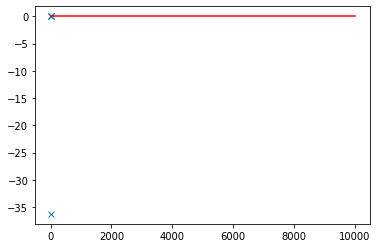

In [67]:
plt.plot(position[:,0],"x")
plt.plot([0,Nmax],[0,0],color='red')

In [315]:
## MSD, mean square displacement
## c_{AA}(∆t) = 1/N * \sum_{j=1}^N A(t_j)*A(t_j + ∆t)

pMSD = np.zeros(Nmax)

for i in range(1,Nmax): ## loop for 
    pMSD[i] = (position[i,0]**2 + pMSD[i-1])/i

In [316]:
pMSD[0:10]

array([0.00000000e+00, 9.51885534e-12, 4.20370542e-11, 2.89404549e-11,
       1.18592850e-11, 1.52675043e-11, 3.35278137e-11, 1.24695941e-11,
       5.21322328e-12, 9.56969152e-11])

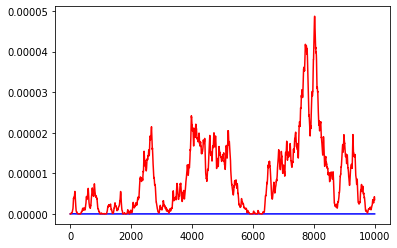

In [318]:
plt.plot(pMSD,color='blue')
plt.plot(position[:,0]**2,color='red')

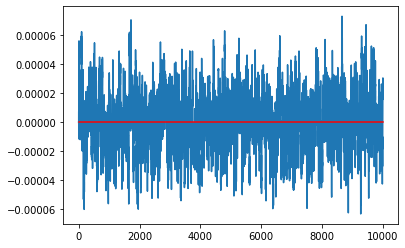

In [319]:
plt.plot(velocity[:,0])
plt.plot([0,Nmax],[0,0],color='red')

In [320]:
## MSD, mean square displacement

vMSD = np.zeros(Nmax)

for i in range(1,Nmax): ## loop for 
    vMSD[i] = (velocity[i,0]**2 +vMSD[i-1])/i

In [321]:
velocity[1:10,0]

array([-7.13177994e-07,  7.36246226e-06, -1.05109522e-05, -1.15989802e-05,
       -7.40218494e-06, -6.60085654e-06,  2.03462053e-05,  1.67839040e-05,
        2.85469269e-05])

In [322]:
velocity[1:10,0]**2

array([5.08622852e-13, 5.42058506e-11, 1.10480117e-10, 1.34536341e-10,
       5.47923419e-11, 4.35713071e-11, 4.13968069e-10, 2.81699435e-10,
       8.14927037e-10])

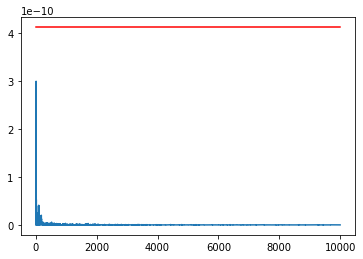

In [324]:
plt.plot(vMSD)
plt.plot([0,Nmax],[1/(beta*m),1/(beta*m)],color='red')

In [330]:
## Verify the Time Correlation Function
## c_{AA}(∆t) = 1/N * \sum_{j=1}^N A(t_j)*A(t_j + ∆t)

vTCF = np.zeros(Nmax)

for i in range(Nmax-1): ## loop for ∆t
    for j in range(Nmax-i): ## loop for t_i
        vTCF[i] = vTCF[i] + velocity[j,0] * velocity[j+i,0]

    vTCF[i] = vTCF[i] / (Nmax-i)



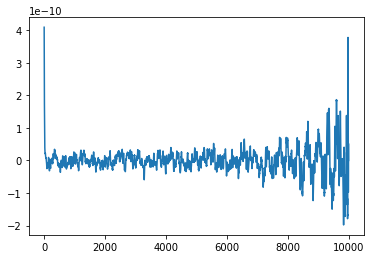

In [331]:
plt.plot(vTCF)
times=range(30)
#plt.plot(np.exp(-gamma*times[0:9])/(beta*m))
#plt.plot(1/(np.exp(times)*beta*m*np.exp(gamma)),color='red')